# 第四章 向量数据库与词向量(Vectorstores and Embeddings)

 - [一、环境配置](#一、环境配置)
 - [二、读取文档](#二、读取文档)
 - [三、Embeddings](#三、Embeddings)
 - [四、Vectorstores](#四、Vectorstores)
     - [4.1 初始化Chroma](#4.1-初始化Chroma)
     - [4.2 相似性搜索(Similarity Search)](#4.2-相似性搜索(Similarity-Search))
 - [五、失败的情况(Failure modes)](#五、失败的情况(Failure-modes))


回顾一下检索增强生成（RAG）的整体工作流程：

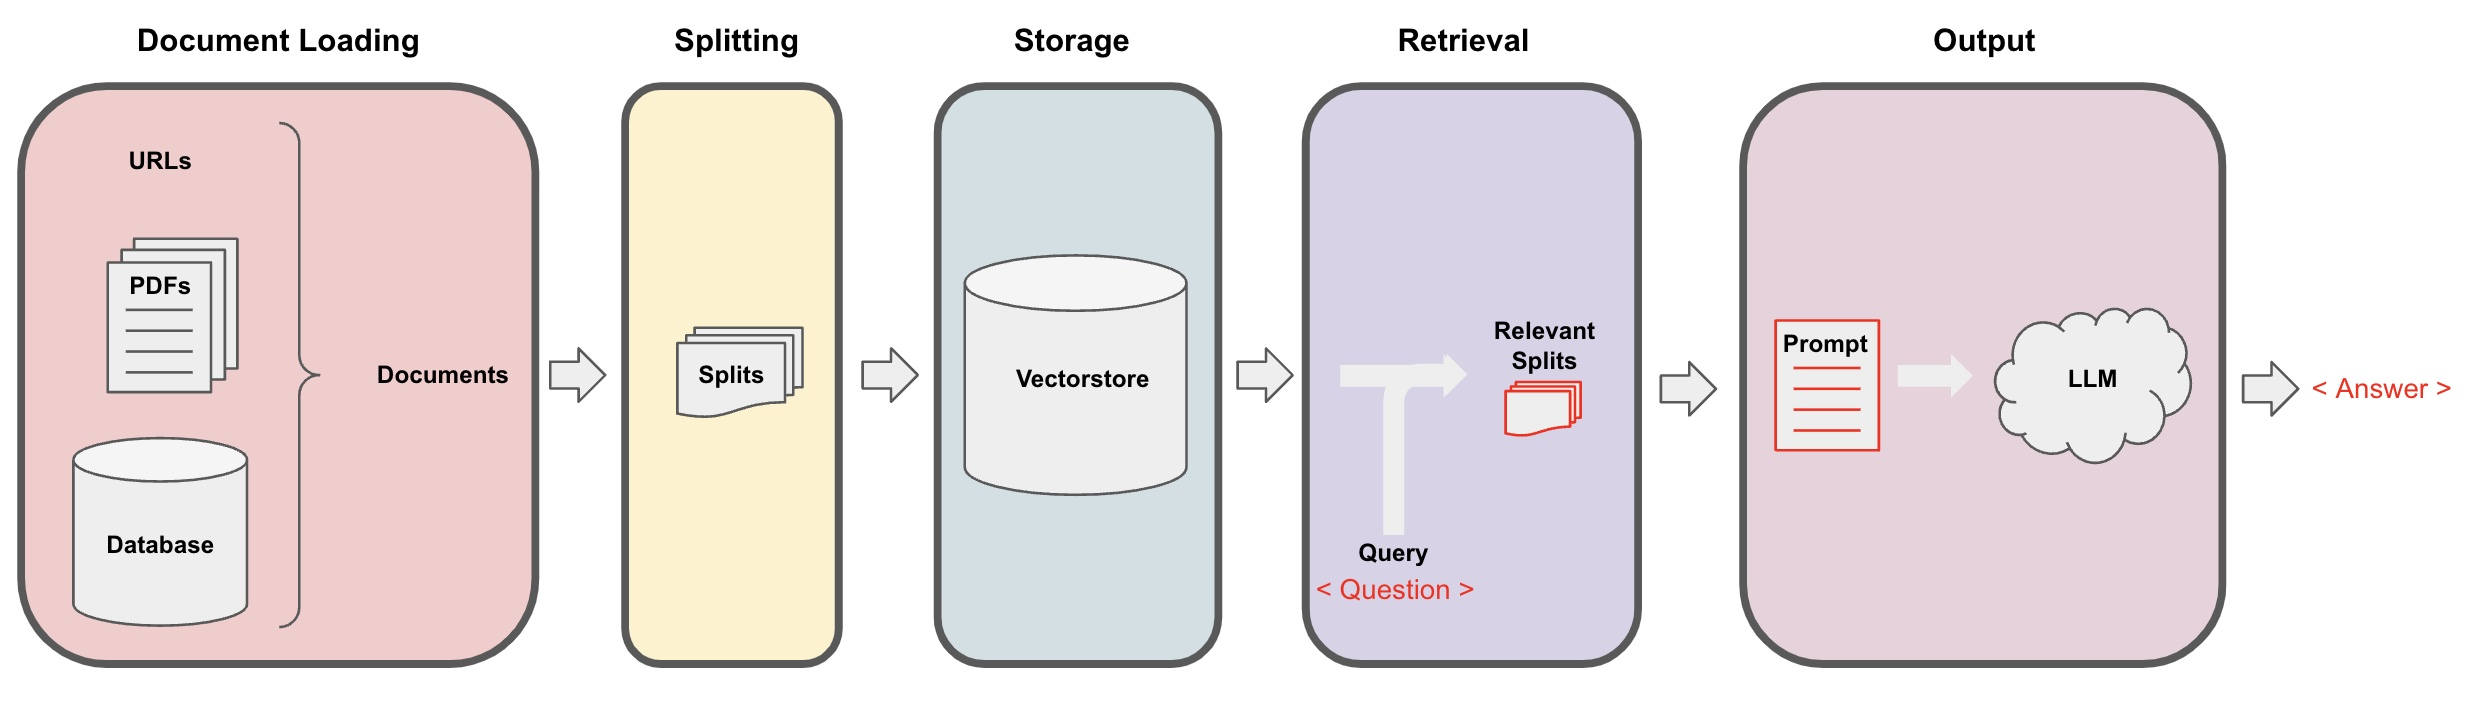

## 一、环境配置

在当前文件夹下新建`.env`文件，内容为`OPENAI_API_KEY = "sk-..."`

由于本章节需要使用`PyPDFLoader`、`Chroma`，故需要安装依赖包`pypdf`、`chromadb`

In [5]:
# !pip install -Uq pypdf
# !pip install -Uq chromadb

In [6]:
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) 


# openai.api_key  = os.environ['OPENAI_API_KEY']

前两节课我们讨论了`Document Loading`（文档加载）和`Splitting`（分割）。

下面我们将使用前两节课的知识对文档进行加载分割。

## 二、读取文档

下面文档的课程链接 https://see.stanford.edu/Course/CS229 ，可在该网站上下载对应的课程讲义

In [7]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter


# 加载 PDF
loaders = [
    # 故意添加重复文档，使数据混乱
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture02.pdf"),
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture03.pdf")
]
docs = []
for loader in loaders:
    docs.extend(loader.load())
    

# 分割文本
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,  # 每个文本块的大小。这意味着每次切分文本时，会尽量使每个块包含 1500 个字符。
    chunk_overlap = 150  # 每个文本块之间的重叠部分。
)

splitted_doc = text_splitter.split_documents(docs)


print(len(splitted_doc))
print(splitted_doc)
print(splitted_doc[0])
    
    
# 下面文档是datawhale官方开源的matplotlib教程链接 https://datawhalechina.github.io/fantastic-matplotlib/index.html ，可在该网站上下载对应的教程
# 加载 PDF
loaders_chinese = [
    # 故意添加重复文档，使数据混乱
    PyPDFLoader("docs/matplotlib/第一回：Matplotlib初相识.pdf"),
    PyPDFLoader("docs/matplotlib/第一回：Matplotlib初相识.pdf"),
    PyPDFLoader("docs/matplotlib/第二回：艺术画笔见乾坤.pdf"),
    PyPDFLoader("docs/matplotlib/第三回：布局格式定方圆.pdf")
]
docs_chinese = []
for loader in loaders_chinese:
    docs_chinese.extend(loader.load())

# 分割文本
chinese_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,  # 每个文本块的大小。这意味着每次切分文本时，会尽量使每个块包含 1500 个字符。
    chunk_overlap = 150  # 每个文本块之间的重叠部分。
)
splitted_chinese = chinese_text_splitter.split_documents(docs_chinese)

# 在文档加载后，使用`RecursiveCharacterTextSplitter`(递归字符文本拆分器)来创建块。
print(len(splitted_chinese))
print(splitted_chinese)
print(splitted_chinese[0])

209
[Document(page_content="MachineLearning-Lecture01  \nInstructor (Andrew Ng):  Okay. Good morning. Welcome to CS229, the machine \nlearning class. So what I wanna do today is ju st spend a little time going over the logistics \nof the class, and then we'll start to  talk a bit about machine learning.  \nBy way of introduction, my name's  Andrew Ng and I'll be instru ctor for this class. And so \nI personally work in machine learning, and I' ve worked on it for about 15 years now, and \nI actually think that machine learning is th e most exciting field of all the computer \nsciences. So I'm actually always excited about  teaching this class. Sometimes I actually \nthink that machine learning is not only the most exciting thin g in computer science, but \nthe most exciting thing in all of human e ndeavor, so maybe a little bias there.  \nI also want to introduce the TAs, who are all graduate students doing research in or \nrelated to the machine learni ng and all aspects of machin e l

## 三、Embeddings

什么是`Embeddings`？

在机器学习和自然语言处理（NLP）中，`Embeddings`（嵌入）是一种将类别数据，如单词、句子或者整个文档，转化为实数向量的技术。这些实数向量可以被计算机更好地理解和处理。嵌入背后的主要想法是，相似或相关的对象在嵌入空间中的距离应该很近。

举个例子，我们可以使用词嵌入（word embeddings）来表示文本数据。在词嵌入中，每个单词被转换为一个向量，这个向量捕获了这个单词的语义信息。例如，"king" 和 "queen" 这两个单词在嵌入空间中的位置将会非常接近，因为它们的含义相似。而 "apple" 和 "orange" 也会很接近，因为它们都是水果。而 "king" 和 "apple" 这两个单词在嵌入空间中的距离就会比较远，因为它们的含义不同。

让我们取出我们的切分部分并对它们进行`Embedding`处理。

在使用真实文档数据的例子之前，让我们用几个测试案例的句子来试试，以便了解`embedding`。

下面有几个示例句子，其中前两个非常相似，第三个与之无关。然后我们可以使用`embedding`类为每个句子创建一个`embedding`。

In [9]:
from langchain.embeddings.openai import OpenAIEmbeddings
embedding_model = OpenAIEmbeddings()

sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"



embedding1 = embedding_model.embed_query(sentence1)
embedding2 = embedding_model.embed_query(sentence2)
embedding3 = embedding_model.embed_query(sentence3)


sentence1_chinese = "我喜欢狗"
sentence2_chinese = "我喜欢犬科动物"
sentence3_chinese = "外面的天气很糟糕"



embedding1_chinese = embedding_model.embed_query(sentence1_chinese)
embedding2_chinese = embedding_model.embed_query(sentence2_chinese)
embedding3_chinese = embedding_model.embed_query(sentence3_chinese)

然后我们可以使用`numpy`来比较它们，看看哪些最相似。

我们期望前两个句子应该非常相似。

然后，第一和第二个与第三个相比应该相差很大。

我们将使用点积来比较两个嵌入。

如果你不知道什么是点积，没关系。你只需要知道的重要一点是，分数越高句子越相似。

我们可以看到前两个`embedding`的分数相当高，为0.96。

如果我们将第一个`embedding`与第三个`embedding`进行比较，我们可以看到它明显较低，约为0.77。

如果我们将第二个`embedding`和第三个`embedding`进行比较，我们可以看到它的分数大约为0.75。

In [10]:
import numpy as np


print(np.dot(embedding1, embedding2))
print(np.dot(embedding1, embedding3))
print(np.dot(embedding2, embedding3))
print("\n\n")


# 我们可以看到前两个`embedding`的分数相当高，为0.94。
# 如果我们将第一个`embedding`与第三个`embedding`进行比较，我们可以看到它明显较低，约为0.79。
# 如果我们将第二个`embedding`和第三个`embedding`进行比较，我们可以看到它的分数大约为0.78。
print(np.dot(embedding1_chinese, embedding2_chinese))
print(np.dot(embedding1_chinese, embedding3_chinese))
print(np.dot(embedding2_chinese, embedding3_chinese))

0.9631853782830291
0.7709172071955229
0.7595538365168842



0.9440615296168726
0.7921870036878481
0.7804110665851218


## 四、Vectorstores

### 4.1 初始化Chroma

Langchain集成了超过30个不同的向量存储库。我们选择Chroma是因为它轻量级且数据存储在内存中，这使得它非常容易启动和开始使用。

In [11]:
from langchain.vectorstores import Chroma
persist_directory = 'docs/chroma/cs229_lectures/'
persist_directory_chinese = 'docs/chroma/matplotlib/'

# # 删除旧的数据库文件（如果文件夹中有文件的话），window电脑请手动删除
# !rm -rf './docs/chroma/cs229_lectures'  
# !rm -rf './docs/chroma/matplotlib'  # 删除旧的数据库文件（如果文件夹中有文件的话）

In [12]:
vector_db = Chroma.from_documents(
    documents=splitted_doc,
    embedding=embedding_model,
    persist_directory=persist_directory  # 允许我们将persist_directory目录保存到磁盘上
)

print(vector_db._collection.count())


vector_db_chinese = Chroma.from_documents(
    documents=splitted_chinese,
    embedding=embedding_model,
    persist_directory=persist_directory_chinese  # 允许我们将persist_directory目录保存到磁盘上
)

print(vector_db_chinese._collection.count())

# 我们可以看到英文版的长度也是209、中文版的长度也是30，这与我们之前的切分数量是一样的。现在让我们开始使用它。

209
27


### 4.2 相似性搜索(Similarity Search)

In [13]:
question = "is there an email i can ask for help"  # "有我可以寻求帮助的电子邮件吗"


docs = vector_db.similarity_search(question,k=3)

# 如果我们查看第一个文档的内容，我们可以看到它实际上是关于一个电子邮件地址，cs229-qa@cs.stanford.edu。
# 这是我们可以向其发送问题的电子邮件，所有的助教都会阅读这些邮件。
print(len(docs))
print(docs[0].page_content)
print()


# 如果我们查看第一个文档的内容，我们可以看到它实际上是关于Matplotlib的介绍
question_chinese = "Matplotlib是什么？" 
docs_chinese = vector_db_chinese.similarity_search(question_chinese,k=3)
print(len(docs_chinese))
print(docs_chinese[0].page_content)
print()


# 在此之后，我们要确保通过运行vectordb.persist来持久化向量数据库，以便我们在未来的课程中使用。

# 让我们保存它，以便以后使用！
vector_db.persist()
vector_db_chinese.persist()

3
cs229-qa@cs.stanford.edu. This goes to an acc ount that's read by all the TAs and me. So 
rather than sending us email individually, if you send email to this account, it will 
actually let us get back to you maximally quickly with answers to your questions.  
If you're asking questions about homework probl ems, please say in the subject line which 
assignment and which question the email refers to, since that will also help us to route 
your question to the appropriate TA or to me  appropriately and get the response back to 
you quickly.  
Let's see. Skipping ahead — let's see — for homework, one midterm, one open and term 
project. Notice on the honor code. So one thi ng that I think will help you to succeed and 
do well in this class and even help you to enjoy this cla ss more is if you form a study 
group.  
So start looking around where you' re sitting now or at the end of class today, mingle a 
little bit and get to know your classmates. I strongly encourage you to form study g

## 五、失败的情况(Failure modes)

这看起来很好，基本的相似性搜索很容易就能让你完成80%的工作。

但是，可能会出现一些相似性搜索失败的情况。

这里有一些可能出现的边缘情况——我们将在下一堂课中修复它们。

请注意，我们得到了重复的块（因为索引中有重复的 `MachineLearning-Lecture01.pdf`、`第一回：Matplotlib初相识.pdf`）。

语义搜索获取所有相似的文档，但不强制多样性。

`docs[0]` 和 `docs[1]` 是完全相同的，以及`docs_chinese[0]` 和 `docs_chinese[1]` 是完全相同的。s

In [14]:
question = "what did they say about matlab?"  # "他们对 matlab 有何评价？"
docs = vector_db.similarity_search(question,k=5)

print(docs[0])
print(docs[1])
print()

question_chinese = "Matplotlib是什么？"
docs_chinese = vector_db_chinese.similarity_search(question_chinese,k=5)

print(docs_chinese[0])
print(docs_chinese[1])
print()

page_content='those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people call it a free ve rsion of MATLAB, which it sort  of is, sort of isn\'t.  \nSo I guess for those of you that haven\'t s een MATLAB before, and I know most of you \nhave, MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to \nplot data. And it\'s sort of an extremely easy to  learn tool to use for implementing a lot of \nlearning algorithms.  \nAnd in case some of you want to work on your  own home computer or something if you \ndon\'t have a MATLAB license, for the purposes of  this class, there\'s also — [inaudible] \nwrite that down [inaudible] MATLAB — there\' s also a software package called Octave \nthat you can download for free off the Internet. And it has somewhat fewer features than MATLAB, but it\'s free, and for the purposes of  this class, it will 

我们可以看到一种新的失败的情况。

下面的问题询问了关于第三讲的问题，但也包括了来自其他讲的结果。

In [15]:
question = "what did they say about regression in the third lecture?"  # "他们在第三讲中是怎么谈论回归的？"
docs = vector_db.similarity_search(question,k=5)
for doc in docs:
    print(doc.metadata)
print(docs[3].page_content)
print()

question_chinese = "他们在第二讲中对Figure说了些什么？" 
docs_chinese = vector_db_chinese.similarity_search(question_chinese,k=5)
for doc_chinese in docs_chinese:
    print(doc_chinese.metadata)
print(docs_chinese[2].page_content)

{'page': 0, 'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 2, 'source': 'docs/cs229_lectures/MachineLearning-Lecture02.pdf'}
{'page': 14, 'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
{'page': 0, 'source': 'docs/cs229_lectures/MachineLearning-Lecture02.pdf'}
{'page': 6, 'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf'}
really makes a difference between a good so lution and amazing solution. And to give 
everyone to just how we do points assignments, or what is it that causes a solution to get 
full marks, or just how to write amazing so lutions. Becoming a grad er is usually a good 
way to do that.  
Graders are paid positions and you also get free  food, and it's usually fun for us to sort of 
hang out for an evening and grade all the a ssignments. Okay, so I will send email. So 
don't email me yet if you want to be a grader. I'll send email to the entire class later with 
the administrative details and to solicit app lications. S

在下一讲中讨论的方法可以用来解决这两个问题！